In [2]:
# Imports
import numpy as np
import networkx as nx
import numpy.random as rnd
from numpy import genfromtxt
import matplotlib.pyplot as plt

In [3]:
# Read CVS files
PATH2_MAT = genfromtxt('./q3dm1-path2.csv', delimiter=',')

## 17.1 SOM2

In [12]:
def initRingSOM(matX, k):
    """
        Initialize SOM topology as grid.
        
        Input:
            matX: matrix of points
            k   : number of neurons
    """
    # Create graph
    G = nx.generators.lattice.grid_2d_graph(k, 1, periodic=True)
    G = nx.convert_node_labels_to_integers(G)
    
    # Get shape of the matrix
    m, n = matX.shape
    
    # Sample k points from our
    # input matrix as our neurons
    smpl = rnd.choice(m, k, replace=False)
    
    # Add nodes to graph using
    # previously sampled points
    for i, v in enumerate(G):
        G.nodes[v]["w"] = matX[smpl[i], :]

    return G

def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1.):
    # Get size of the matrix
    m, n = matX.shape
    
    # Compute matrix of squared path length 
    # distances between neurons.
    #
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    # because this allows for easy squaring of its entries
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    
    # A list of tmax random indices
    smpl = rnd.randint(0, m, size=tmax)
    
    for t in range(tmax):
        # Sample a point x
        vecX = matX[smpl[t], :]
        
        # Determine the best matching unit
        b = np.argmin([np.sum((G.nodes[v]["w"] - vecX)**2) for v in G])
        
        # Update the learning rate
        eta = eta0 * (1. - t/tmax)
        
        # Update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        
        # Update all weights
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            G.nodes[v]["w"] += eta * h * (vecX - G.nodes[v]["w"])
    
    return G

In [13]:
# Create two separate topologies
G1 = initRingSOM(PATH2_MAT, 10)
G2 = initRingSOM(PATH2_MAT, 10)

In [14]:
# Create merged topology
G3 = nx.union(G1 ,G2, rename=('a', 'b'))
G3.add_edge('a0', 'b0')

# nx.draw_networkx(c,with_labels=True,node_size=500)
# plt.show()

# Train SOM
SOM = trainSOM(PATH2_MAT, G3)

## Plots

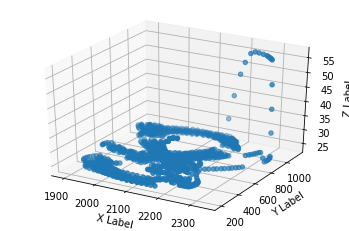

In [15]:
matX = np.genfromtxt('q3dm1-path2.csv',delimiter=',')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1], matX[:,0], matX[:,2], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

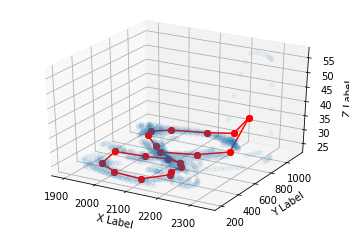

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1], matX[:,0], matX[:,2], marker='o', alpha=0.05)

# Draw SOM topology
for x in range(len(SOM.nodes())//2 - 1):
    ax.plot([SOM.nodes()["a"+str(x)]["w"][1], SOM.nodes()["a"+str(x+1)]["w"][1]],
            [SOM.nodes()["a"+str(x)]["w"][0], SOM.nodes()["a"+str(x+1)]["w"][0]],
            [SOM.nodes()["a"+str(x)]["w"][2], SOM.nodes()["a"+str(x+1)]["w"][2]],
            'ro-')
    
    ax.plot([SOM.nodes()["b"+str(x)]["w"][1], SOM.nodes()["b"+str(x+1)]["w"][1]],
            [SOM.nodes()["b"+str(x)]["w"][0], SOM.nodes()["b"+str(x+1)]["w"][0]],
            [SOM.nodes()["b"+str(x)]["w"][2], SOM.nodes()["b"+str(x+1)]["w"][2]],
            'ro-')

# Add cyclic connection and union
ax.plot([SOM.nodes()["a"+str(0)]["w"][1], SOM.nodes()["a"+str(9)]["w"][1]],
        [SOM.nodes()["a"+str(0)]["w"][0], SOM.nodes()["a"+str(9)]["w"][0]],
        [SOM.nodes()["a"+str(0)]["w"][2], SOM.nodes()["a"+str(9)]["w"][2]],
        'ro-')

ax.plot([SOM.nodes()["b"+str(0)]["w"][1], SOM.nodes()["b"+str(9)]["w"][1]],
        [SOM.nodes()["b"+str(0)]["w"][0], SOM.nodes()["b"+str(9)]["w"][0]],
        [SOM.nodes()["b"+str(0)]["w"][2], SOM.nodes()["b"+str(9)]["w"][2]],
        'ro-')

ax.plot([SOM.nodes()["a"+str(0)]["w"][1], SOM.nodes()["b"+str(0)]["w"][1]],
        [SOM.nodes()["a"+str(0)]["w"][0], SOM.nodes()["b"+str(0)]["w"][0]],
        [SOM.nodes()["a"+str(0)]["w"][2], SOM.nodes()["b"+str(0)]["w"][2]],
        'ro-')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## 17.2 SOM batch training

In [104]:
def batchTrainSOM(matX, G, tmax=1000, sigma0=1., eta0=1.):
    # Size of X
    N_X = 50
    
    # Get size of the matrix
    m, n = matX.shape
    
    # Compute matrix of squared path length 
    # distances between neurons.
    #
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    # because this allows for easy squaring of its entries
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    
    # Create matrix X
    X = matX[rnd.randint(0, m, size=N_X)]
    
    for t in range(tmax):        
        # Matching distances
        b = []
        
        # Iterate over all points in X
        for vecX in X:
            # Determine the best matching unit
            b.append(np.argmin([np.sum((G.nodes[v]["w"] - vecX)**2) for v in G]))
                
        # Update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        
        # Update all weights
        for i, v in enumerate(G):
            # Compute sum over js
            num_sum = 0
            den_sum = 0
            
            for j, vecX in enumerate(X):
                num_sum += vecX * np.exp(-0.5 * matD[b[j],i] / sigma**2)
                den_sum += np.exp(-0.5 * matD[b[j],i] / sigma**2)
            
            # Update weight
            G.nodes[v]["w"] = num_sum / den_sum
    
    return G

In [105]:
# Train online batch
SOM_BATCH = batchTrainSOM(PATH2_MAT, G3)

## Plots

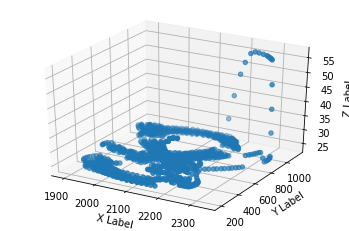

In [106]:
matX = np.genfromtxt('q3dm1-path2.csv',delimiter=',')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1], matX[:,0], matX[:,2], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

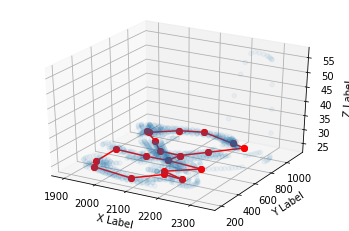

In [107]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1], matX[:,0], matX[:,2], marker='o', alpha=0.05)

# Draw SOM_BATCH topology
for x in range(len(SOM_BATCH.nodes())//2 - 1):
    ax.plot([SOM_BATCH.nodes()["a"+str(x)]["w"][1], SOM_BATCH.nodes()["a"+str(x+1)]["w"][1]],
            [SOM_BATCH.nodes()["a"+str(x)]["w"][0], SOM_BATCH.nodes()["a"+str(x+1)]["w"][0]],
            [SOM_BATCH.nodes()["a"+str(x)]["w"][2], SOM_BATCH.nodes()["a"+str(x+1)]["w"][2]],
            'ro-')
    
    ax.plot([SOM_BATCH.nodes()["b"+str(x)]["w"][1], SOM_BATCH.nodes()["b"+str(x+1)]["w"][1]],
            [SOM_BATCH.nodes()["b"+str(x)]["w"][0], SOM_BATCH.nodes()["b"+str(x+1)]["w"][0]],
            [SOM_BATCH.nodes()["b"+str(x)]["w"][2], SOM_BATCH.nodes()["b"+str(x+1)]["w"][2]],
            'ro-')

# Add cyclic connection and union
ax.plot([SOM_BATCH.nodes()["a"+str(0)]["w"][1], SOM_BATCH.nodes()["a"+str(9)]["w"][1]],
        [SOM_BATCH.nodes()["a"+str(0)]["w"][0], SOM_BATCH.nodes()["a"+str(9)]["w"][0]],
        [SOM_BATCH.nodes()["a"+str(0)]["w"][2], SOM_BATCH.nodes()["a"+str(9)]["w"][2]],
        'ro-')

ax.plot([SOM_BATCH.nodes()["b"+str(0)]["w"][1], SOM_BATCH.nodes()["b"+str(9)]["w"][1]],
        [SOM_BATCH.nodes()["b"+str(0)]["w"][0], SOM_BATCH.nodes()["b"+str(9)]["w"][0]],
        [SOM_BATCH.nodes()["b"+str(0)]["w"][2], SOM_BATCH.nodes()["b"+str(9)]["w"][2]],
        'ro-')

ax.plot([SOM_BATCH.nodes()["a"+str(0)]["w"][1], SOM_BATCH.nodes()["b"+str(0)]["w"][1]],
        [SOM_BATCH.nodes()["a"+str(0)]["w"][0], SOM_BATCH.nodes()["b"+str(0)]["w"][0]],
        [SOM_BATCH.nodes()["a"+str(0)]["w"][2], SOM_BATCH.nodes()["b"+str(0)]["w"][2]],
        'ro-')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [99]:
matD[0,0]

0.0